# Ανάλυση Κατασκεύων σε Η/Υ - Άσκηση 2 (Μαρτ.2021)

In [1]:
from streng.ppp.sections.geometry.rectangular import RectangularSectionGeometry
from streng.ppp.sections.geometry.tee import TeeSectionGeometry
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opsvis as opsv

## Εισαγωγή αριθμού μητρώου φοιτητών

Αντικαταστήστε τα ψηφία με αυτά του αριθμού μητρώου σας και τρέξτε το jupyter notebook.  
Δε θα χρειαστεί να κάνετε κάποια άλλη αλλαγή ή κάποια εισαγωγή δεδομένων

In [2]:
κ, λ, μ, ν = 9, 8, 7, 6

## Δεδομένα

In [3]:
# Δεδομένα φοιτητών βάσει ΑΕΜ
H=2.7+0.1*(λ+μ)
L=4.5+0.1*(κ+ν)
if ν<5:
    bc=hc=0.45
    bw=0.25
    h=0.65
    hf=0.20
    beff=1.40
else:
    bc=hc=0.50
    bw=0.30
    h=0.70
    hf=0.20
    beff=1.50

F=100.+μ+ν
G=15.+λ+ν
Q=8.+ν
   
E=2.8*10**7
U = 0.0

# # # Δεδομένα παραδείγματος βιβλίου
# H=3.0
# L=5
# bc=hc=0.4
# bw=0.25
# h=0.70
# hf=0.15
# beff=1.20

# F=100.
# G=20.
# Q=10.

In [4]:
print(f'H = {H:.2f}m')
print(f'L = {L:.2f}m')
print(f'bc = hc = {bc:.2f}m')
print(f'bw = {bw:.2f}m')
print(f'h = {h:.2f}m')
print(f'hf = {hf:.2f}m')
print(f'beff = {beff:.2f}m')

print(f'E = {F:.2f}kN')
print(f'G = {G:.2f}kN/m')
print(f'Q = {Q:.2f}kN/m')

H = 4.20m
L = 6.00m
bc = hc = 0.50m
bw = 0.30m
h = 0.70m
hf = 0.20m
beff = 1.50m
E = 113.00kN
G = 29.00kN/m
Q = 14.00kN/m


## Επίλυση με το OpenSees

In [5]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

U = 0.0
G_shear = E / (2.0*(1.0+U))

rect_col = RectangularSectionGeometry(b=bc, h=hc)
A_col = rect_col.area
Iz_col = rect_col.moment_of_inertia_xx * 0.5
Avy_col = rect_col.shear_area_2 * 0.5

tbeam = TeeSectionGeometry(bw = bw, h = h, beff=beff, hf = hf)
A_tbeam = tbeam.area
Iz_tbeam = tbeam.moment_of_inertia_xx * 0.5
Avy_tbeam = tbeam.shear_area_2 * 0.5

ops.node(1, 0., 0.)
ops.node(2, L, 0.)
ops.node(3, 0., H)
ops.node(4, L, H)

ops.fix(1, 1, 1, 1)
ops.fix(2, 1, 1, 1)

ops.equalDOF(4, 3, 1)
    
ops.geomTransf('Linear', 1)

ops.element('ElasticTimoshenkoBeam', 1, 1, 3, E, G_shear, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 2, 2, 4, E, G_shear, A_col, Iz_col, Avy_col, 1)  # , '-mass', 0., '-lMass')
ops.element('ElasticTimoshenkoBeam', 3, 3, 4, E, G_shear, A_tbeam, Iz_tbeam, Avy_tbeam, 1)  # , '-mass', 0., '-lMass')

results_ele = []
results_node = []

# F Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.load(3, F, 0., 0.)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

for i in range(3):
    el_num=i+1
    results_ele.append(['F', el_num, ops.eleForce(el_num)])
results_node.append(['F', ops.nodeDisp(3)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()


# G Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 3, '-type', '-beamUniform', -G)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

for i in range(3):
    el_num=i+1
    results_ele.append(['G', el_num, ops.eleForce(el_num)])
results_node.append(['G', ops.nodeDisp(3)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()


# Q Analysis
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)
ops.eleLoad('-ele', 3, '-type', '-beamUniform', -Q)
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

for i in range(3):
    el_num=i+1
    results_ele.append(['Q', el_num, ops.eleForce(el_num)])
results_node.append(['Q', ops.nodeDisp (3)])

ops.remove('timeSeries', 1)
ops.remove('loadPattern', 1)
ops.wipeAnalysis()



<Figure size 1000x600 with 0 Axes>

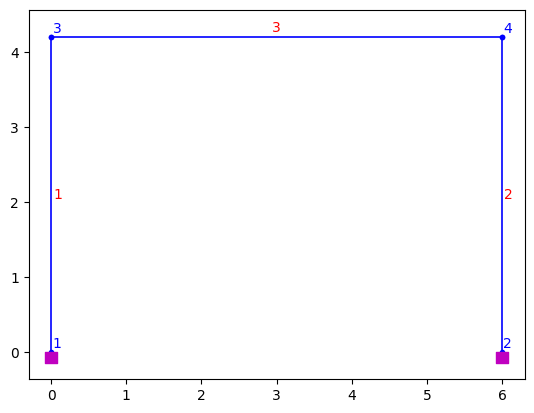

In [6]:
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=.08, bottom=.08, right=.94, top=.94)
# ax1 = plt.subplot(111)

opsv.plot_model();

## Εμφάνιση αποτελεσμάτων

### Εντατικά μεγέθη για κάθε load pattern

- Στύλοι:
>-Vi, -Ni, Mi, Vj, Nj, -Mj

- Δοκοί:
>-Ni, -Vi, -Mi, Nj, Vj, Mj

In [7]:
for re in results_ele:
    print(f'Για φόρτιση {re[0]}, στο στοιχείο {re[1]}: {np.round(re[2],2)}')

Για φόρτιση F, στο στοιχείο 1: [-56.5  -36.59 127.52  56.5   36.59 109.78]
Για φόρτιση F, στο στοιχείο 2: [-56.5   36.59 127.52  56.5  -36.59 109.78]
Για φόρτιση F, στο στοιχείο 3: [   0.    -36.59 -109.78    0.     36.59 -109.78]
Για φόρτιση G, στο στοιχείο 1: [ 14.48  87.   -19.92 -14.48 -87.   -40.88]
Για φόρτιση G, στο στοιχείο 2: [-14.48  87.    19.92  14.48 -87.    40.88]
Για φόρτιση G, στο στοιχείο 3: [  0.    87.    40.88   0.    87.   -40.88]
Για φόρτιση Q, στο στοιχείο 1: [  6.99  42.    -9.62  -6.99 -42.   -19.73]
Για φόρτιση Q, στο στοιχείο 2: [ -6.99  42.     9.62   6.99 -42.    19.73]
Για φόρτιση Q, στο στοιχείο 3: [  0.    42.    19.73   0.    42.   -19.73]


### Αποτελέσματα εντατικών μεγεθών για τα ζητούμενα της εκφώνησης

In [8]:
print('Για 1.35G+1.5Q')
print(f'M_A= {(1.35*results_ele[3][2][2] + 1.5*results_ele[6][2][2]):.2f}kNm')
print(f'M_B= {(1.35*results_ele[4][2][2] + 1.5*results_ele[7][2][2]):.2f}kNm')
print(f'M_C= {(-1)*(1.35*results_ele[5][2][2] + 1.5*results_ele[8][2][2]):.2f}kNm')
print(f'M_D= {(1.35*results_ele[5][2][5] + 1.5*results_ele[8][2][5]):.2f}kNm')
print()
print('Για G+0.3Q+E')
print(f'M_A= {(results_ele[3][2][2] + 0.3*results_ele[6][2][2] + results_ele[0][2][2]):.2f}kNm')
print(f'M_B= {(results_ele[4][2][2] + 0.3*results_ele[7][2][2] + results_ele[1][2][2]):.2f}kNm')
print(f'M_C= {(-1)*(results_ele[5][2][2] + 0.3*results_ele[8][2][2] + results_ele[2][2][2]):.2f}kNm')
print(f'M_D= {(results_ele[5][2][5] + 0.3*results_ele[8][2][5] + results_ele[2][2][5]):.2f}kNm')

Για 1.35G+1.5Q
M_A= -41.32kNm
M_B= 41.32kNm
M_C= -84.79kNm
M_D= -84.79kNm

Για G+0.3Q+E
M_A= 104.71kNm
M_B= 150.33kNm
M_C= 62.98kNm
M_D= -156.58kNm


### Μετακινήσεις για τα load patterns

In [9]:
for re in results_node:
    print(f'Για φόρτιση {re[0]}: δ={100*re[1][0]:.2f}cm')

Για φόρτιση F: δ=0.60cm
Για φόρτιση G: δ=0.00cm
Για φόρτιση Q: δ=0.00cm


### Αποτελέσματα μετακινήσεων για τα ζητούμενα της εκφώνησης

In [10]:
print('Για 1.35G+1.5Q')
print(f'δ=0.0cm')
print()
print('Για G+0.3Q+E')
print(f'δ={(100*results_node[0][1][0]):.2f}cm')

Για 1.35G+1.5Q
δ=0.0cm

Για G+0.3Q+E
δ=0.60cm
